In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import sys, json

# Update path to look for NCF modle in adjacent directory
# You may need to create a folder and move the NCF model there, as well as change this appended path
sys.path.append('../../')
import Collaborative_Filtering.models.ncf_model as ncf
from utils import HybridCF

2024-12-06 04:48:08.001149: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 04:48:08.005092: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-06 04:48:08.014793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733478488.032481    8079 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733478488.047585    8079 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 04:48:08.062804: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
eval_data = pd.read_csv('../data/sampled_interactions.csv')
eval_data = eval_data.drop(columns=['Unnamed: 0'])
eval_data['liked'] = (eval_data['count'] > 0).astype(int)

## Create the numerical mappings for user ids.
user_mapping = {}
for index, user_id in enumerate(eval_data['user'].unique()):
    user_mapping[user_id] = index

## Create the numerical mappings for song ids.
song_mapping = {}
for index, song_id in enumerate(eval_data['track'].unique()):
    song_mapping[song_id] = index
    
inv_user_mapping = {v: k for k, v in user_mapping.items()}
inv_song_mapping = {v: k for k, v in song_mapping.items()}

## Map the raw user and song ids to the created numerical values.
eval_data['user_id'] = eval_data['user'].map(user_mapping)
eval_data['song_id'] = eval_data['track'].map(song_mapping)

eval_data.head()

,user,track,count,liked,user_id,song_id
0,0ef42a19efb74d0a05c308d00636c8d8d41bec0c,TRBHLDQ128F423EF10,2,1,0,0
1,537340ff896dea11328910013cfe759413e1eeb3,TRARUTP128E0797FC7,1,1,1,1
2,999902c7302ca251b23f5c0d643debce084076d3,TRBGQAB128E07877E4,1,1,2,2
3,2d4df82baf7a0c2f39706a40c25f96fa0c61ef19,TRAAKDG128F42A0ECB,2,1,3,3
4,e6fbcdd689ac0e85992536933f1f86503310447f,TRADKAX128E0786B92,1,1,4,4


In [3]:
eval_pairs = list(eval_data[['user', 'track', 'count', 'liked']].itertuples(index=False, name=None))
eval_pairs[:5]

[('0ef42a19efb74d0a05c308d00636c8d8d41bec0c', 'TRBHLDQ128F423EF10', 2, 1),
 ('537340ff896dea11328910013cfe759413e1eeb3', 'TRARUTP128E0797FC7', 1, 1),
 ('999902c7302ca251b23f5c0d643debce084076d3', 'TRBGQAB128E07877E4', 1, 1),
 ('2d4df82baf7a0c2f39706a40c25f96fa0c61ef19', 'TRAAKDG128F42A0ECB', 2, 1),
 ('e6fbcdd689ac0e85992536933f1f86503310447f', 'TRADKAX128E0786B92', 1, 1)]

In [4]:
## Determine the total number of unique users.
num_users = eval_data['user_id'].nunique()
## Determine the total number of unique songs.
num_items = eval_data['song_id'].nunique()
## Determine the number of latent features.
num_latent = 8

num_users, num_items, num_latent

(1000, 384, 8)

In [5]:
with open('../data/msd_user_setlists.json', 'r') as f:
    user_setlists = json.load(f)

In [6]:
users = set(eval_data['user_id'].unique())
all_tracks = set(eval_data['song_id'].unique())

len(users), len(all_tracks)

(1000, 384)

In [7]:
# Generate negative samples
RAND_SEED = 916
rand = np.random.default_rng(RAND_SEED)

n_samples = 1

for i, user in enumerate(users):
    if i % 250 == 0:
        print(f'{i}/{num_users} | {i/num_users * 100:.2f}%', end='\r')
        
    user_tracks = set([t for t in user_setlists[inv_user_mapping[user]]])
    negative_choice_pool = [ inv_song_mapping[t] for t in all_tracks if inv_song_mapping[t] not in user_tracks ]
    
    negative_choices = rand.choice(negative_choice_pool, size=n_samples, replace=False)
    eval_pairs.extend([(inv_user_mapping[user], t, 0, 0) for t in negative_choices])

In [8]:
## Initalize the NCF model.
# Using magic numbers from pretrained model
ncf_model = ncf.NCFModel(404103, 3419, 8)

## Pass through random inputs to initialize the weights in the model.
ncf_model(np.array([np.array([0]), np.array([1])]))

## Now load in the trained weights from the MSD dataset.
ncf_model.load_weights('saved_models/ncf_msd_weights.h5')

2024-12-06 04:48:11.370842: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [9]:
# Initialize and load hybrid CF model
hybrid_model = HybridCF('subset_final')

In [10]:
# Generates a prediction for a given song and user, weighting the NCF and CF predictions
# Weights add up to one - if `ncf_weight` is 0.5, then the NCF and CF predictions are weighted equally
# or, if `ncf_weight` is 0.7, then CF weight is 0.7
def generate_combo_prediction(pairs: list[tuple[str, str]], ncf_weight: float, *, clamp_cf_rating: str, verbose: bool):
    n_pairs = len(pairs)
    
    users = np.array([user_mapping[pair[0]] for pair in pairs])
    tracks = np.array([song_mapping[pair[1]] for pair in pairs])
    
    cf_predictions = np.empty(n_pairs, dtype=float)
    
    print('Generating CF predictions...')
    for i, pair in enumerate(pairs):
        if i % 100 == 0:
            print(f'>> {i}/{n_pairs} | {i/n_pairs*100:.2f}%', end='\r')
        cf_predictions[i] = hybrid_model.predict_rating(pair[0], pair[1])
    print()
    
    if clamp_cf_rating == 'full':
        cf_predictions = np.clip(cf_predictions, None, 1)
    elif clamp_cf_rating == 'sqrt':
        cf_predictions = np.sqrt(cf_predictions)
    elif clamp_cf_rating == 'log':
        cf_predictions = np.log(cf_predictions + 1)
    
    print('Generating NCF predictions...')
    ncf_predictions = ncf_model.predict([users, tracks], verbose=int(verbose))[:, 0]
        
    return ncf_weight * ncf_predictions + (1 - ncf_weight) * cf_predictions

In [11]:
ncf_weights = [0.1 * i for i in range (0, 11)]
subset_size = 20_000
num_pairs = subset_size

eval_pair_data = [(pair[0], pair[1]) for pair in eval_pairs[:subset_size]]
liked_data = np.array([pair[3] for pair in eval_pairs[:subset_size]])

hits = {weight: None for weight in ncf_weights} # Empty value to be overwritten
errors = {weight: None for weight in ncf_weights} # Empty value to be overwritten

clamp = 'log'
for weight in ncf_weights:
    print(f'Evaluating at {weight=} ({clamp=})...')
    
    predictions = generate_combo_prediction(eval_pair_data, weight, clamp_cf_rating=clamp, verbose=True)
    
    errors[weight] = np.abs(predictions - liked_data)
    hits[weight] = (np.round(predictions) == liked_data).astype(int)
         
    print('=====================================')

Evaluating at weight=0.0 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluating at weight=0.1 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating at weight=0.2 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluating at weight=0.30000000000000004 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating at weight=0.4 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluating at weight=0.5 (clamp='log')...
Generating CF predictions...
>> 1900/2000 | 95.00%
Generating NCF predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluating a

Text(0.5, 0.98, 'Hybrid Model: log Clamp ')

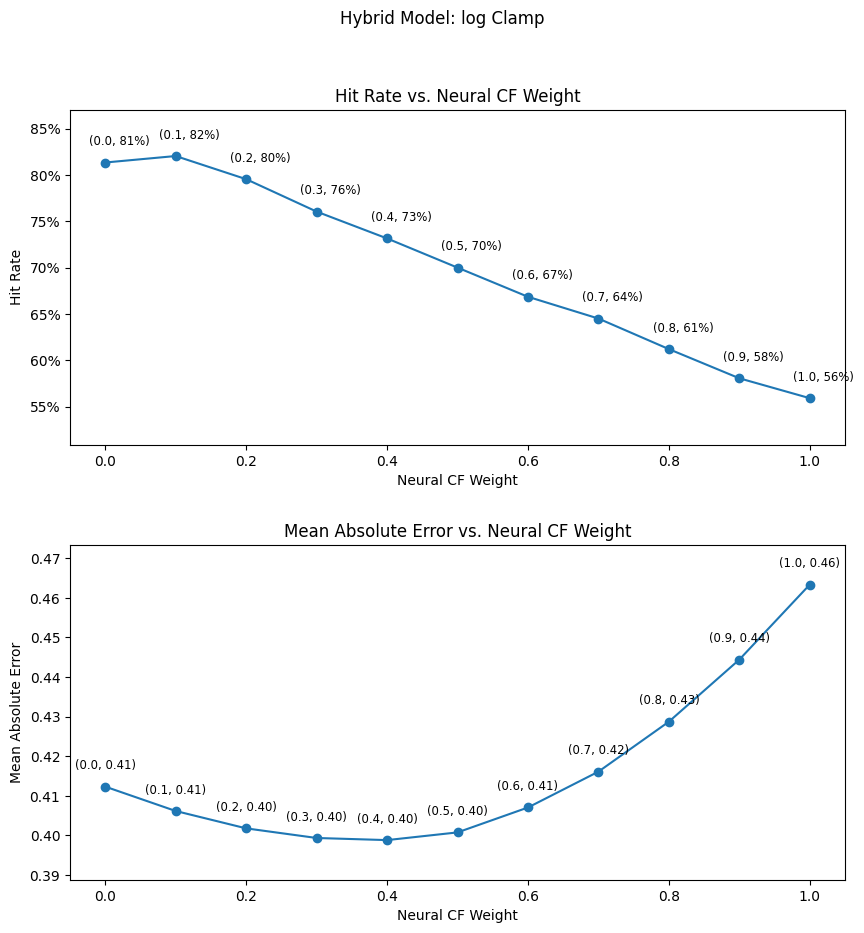

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.3})
hit_plot, error_plot = axs

# np.mean returns hit rate as a percentage
hit_rates = [np.mean(hits[weight]) for weight in ncf_weights]

hit_plot.set_ylim(min(hit_rates) - 0.05, max(hit_rates) + 0.05)
hit_plot.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
hit_plot.plot(ncf_weights, hit_rates, marker='o')

for i, weight in enumerate(ncf_weights):
    hit_plot.text(weight + 0.02, hit_rates[i] + 0.03, f'({weight:.1f}, {hit_rates[i]*100:.0f}%)', ha='center', va='top', fontsize='small')

hit_plot.set_xlabel('Neural CF Weight')
hit_plot.set_ylabel('Hit Rate') 
hit_plot.set_title('Hit Rate vs. Neural CF Weight')


mean_abs_errors = [np.mean(errors[weight]) for weight in ncf_weights]

error_plot.set_ylim(min(mean_abs_errors) - 0.01, max(mean_abs_errors) + 0.01)
error_plot.plot(ncf_weights, mean_abs_errors, marker='o')

for i, weight in enumerate(ncf_weights):
    error_plot.text(weight, mean_abs_errors[i] + 0.007, f'({weight:.1f}, {mean_abs_errors[i]:.2f})', ha='center', va='top', fontsize='small')

error_plot.set_xlabel('Neural CF Weight')
error_plot.set_ylabel('Mean Absolute Error')
error_plot.set_title('Mean Absolute Error vs. Neural CF Weight')

plt.suptitle(f'Hybrid Model: {clamp} Clamp ')